In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [132]:
class Forecaster():
    '''
    Object class to retrieve prices, forecast, and determine buy/sell actions
    '''
    def __init__(self):
        self.tickers = {}


    def forecast(self, ticker, period='5y', interval='1wk', order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)):
        stock = yf.Ticker(ticker)
        # print(stock.info)

        # get historical market data
        df = stock.history(period=period, interval=interval)
        if interval == '1wk':
            ts = df[['Close']].to_period('W')
        model = ARIMA(ts, order=order,seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.predict(start=len(df), end = len(df)+seasonal_order[-1], dynamic=False)     
        self.tickers[ticker] = {'ts': ts, 'forecast': forecast}
    
    def plot_forecast(self, ticker):
        try:
            ticker = self.tickers.get(ticker, None)
            ts, forecast = ticker.get('ts', None), ticker.get('forecast', None)
            # Use .to_timestamp() to convert period back into timestamp for plotting
            plt.plot(ts.to_timestamp())
            plt.plot(forecast.to_timestamp())
        except AttributeError:
            raise AttributeError(f'No forecasting done yet for {ticker}')
            

    def find_max_profit(self, ticker):
        ticker = self.tickers.get(ticker, None)     
        try:
            forecast = ticker.get('forecast', None)  
            max_profit = 0
            high, low = None, None
            last_profit = None
            data = {}
            for period, price in zip(forecast.index, forecast):
                data[period] = dict(current=price)
                if not low or not high:
                    low = high = price

                # Find new lows
                if price < low:
                    low, low_idx = price, period
                    high, high_idx = price, period # reset the high
                    data[period]['new_low'] = price

                # Find new highs
                if price > high:
                    high = price
                    high, high_idx = price, period
                    data[period]['new_high'] = price

                # Calculate and check profit
                profit = round((high - low)/low * 100, 2)
                if profit > 0:
                    if profit != last_profit:
                        data[period]['profit %'] = profit
                last_profit = profit

                # Record the new max_profit
                if profit > max_profit:
                    max_profit, buy, sell = profit, low_idx, high_idx
                    data[period]['new_max_profit'] = profit

            data[buy]['action'], data[sell]['action'] = 'buy', 'sell'
            df = pd.DataFrame(data).T
            df = df.fillna('')
            df = df[['current', 'profit %', 'new_low', 'new_high', 'new_max_profit', 'action']]
            ticker['actions'] = df
            actions = df[(df['action']=='buy') | (df['action']=='sell')][['current', 'profit %', 'action']]
            return actions

        except AttributeError:
            raise AttributeError(f'No forecasting done yet for {ticker}')
        except Exception:
            raise Exception


C:\Users\stell\AppData\Local\Temp\ipykernel_11440\2580087935.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts = df[['Close']].to_period('W')


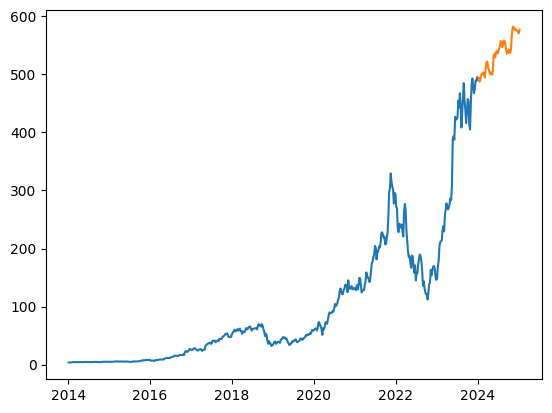

In [133]:
forecaster = Forecaster()

forecaster.forecast(
    'NVDA',
    period='10y', 
    interval='1wk', 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 52))

forecaster.plot_forecast('NVDA')

In [134]:
forecaster.find_max_profit('NVDA')

,current,profit %,action
2024-01-15/2024-01-21,487.505980,,buy
2024-11-11/2024-11-17,582.534941,19.49,sell


In [82]:
# def determine_actions(row, max_profit):
#     if row['new_low']>0:
#         return 'buy'
#     elif row['new_high'] and row['new_max_profit']!= max_profit:
#         return 'hold'
#     else:
#         return 'sell'

# df, max_profit = find_max_profit(out_of_sample_predictions)
# df['actions'] = df.apply(determine_actions, axis=1, args=[max_profit])
# df